# STEP 3 – FEATURE EXTRACTION & ENGINEERING

# PART 1 – Imports & Settings

In [4]:
# ==================== PART 1: Imports & Settings (FULLY FIXED) ====================
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.transforms import InterpolationMode
import numpy as np
from PIL import Image
from pathlib import Path
import json
import matplotlib.pyplot as plt
import random

# --- scikit-image fixed imports ---
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import moments, moments_hu
from skimage.color import rgb2gray

from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load class names
with open("class_names.json", "r") as f:
    class_names = json.load(f)

# Folders
SPLITS_ROOT = "splits"
FEATURES_ROOT = "features"
os.makedirs(FEATURES_ROOT, exist_ok=True)

print("Part 1 ready – all imports fixed!")

Using device: cpu
Part 1 ready – all imports fixed!


# PART 2 – Load Datasets (No Augmentation for Features)

In [5]:
# ==================== PART 2: Transforms + Dataset Class (NOW INCLUDED) ====================
def get_transforms(modality, phase="test"):
    size = 224
    if phase == "test" or phase == "val":
        return transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225]),
        ])
    else:
        # Train augmentations (same as Step 2)
        if modality == "pet":
            return transforms.Compose([
                transforms.Resize((size, size), interpolation=InterpolationMode.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(25),
                transforms.RandomResizedCrop(size, scale=(0.8, 1.0)),
                transforms.ColorJitter(brightness=0.4, contrast=0.4),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225]),
            ])
        else:
            return transforms.Compose([
                transforms.RandomResizedCrop(size, scale=(0.8, 1.0)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(20),
                transforms.ColorJitter(brightness=0.3, contrast=0.3),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225]),
            ])

class BrainTumorDataset(Dataset):
    def __init__(self, modality, split="train", task="binary", transform=None):
        self.modality = modality
        self.split = split
        self.task = task
        self.transform = transform
        
        base_path = Path(SPLITS_ROOT) / modality / split
        self.samples = []
        
        # Healthy
        healthy_path = base_path / "Healthy"
        if healthy_path.exists():
            for p in healthy_path.glob("*.*"):
                if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp"}:
                    self.samples.append((str(p), 0))
        
        # Tumor
        tumor_path = base_path / "Tumor"
        if tumor_path.exists():
            if task == "binary":
                for sub in tumor_path.iterdir():
                    if sub.is_dir():
                        for p in sub.glob("*.*"):
                            if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp"}:
                                self.samples.append((str(p), 1))
            else:  # multiclass
                label_map = {"Glioma":0, "Meningioma":1, "Pituitary":2}
                for sub, lbl in label_map.items():
                    folder = tumor_path / sub
                    if folder.exists():
                        for p in folder.glob("*.*"):
                            if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp"}:
                                self.samples.append((str(p), lbl))
        
        print(f"{modality.upper()} {split} {task}: {len(self.samples)} images")

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

# Create feature loaders (NO augmentation)
modalities = ['mri', 'ct', 'pet']
tasks = ['binary', 'multiclass']
splits = ['train', 'val', 'test']

feature_loaders = {}
for mod in modalities:
    for task in tasks:
        key = f"{mod}_{task}"
        transform = get_transforms(mod, "test")
        for split in splits:
            dataset = BrainTumorDataset(mod, split, task, transform)
            feature_loaders[f"{key}_{split}"] = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

print("Part 2 complete – datasets & loaders ready!")

MRI train binary: 3529 images
MRI val binary: 442 images
MRI test binary: 442 images
MRI train multiclass: 3529 images
MRI val multiclass: 442 images
MRI test multiclass: 442 images
CT train binary: 3694 images
CT val binary: 462 images
CT test binary: 462 images
CT train multiclass: 3694 images
CT val multiclass: 462 images
CT test multiclass: 462 images
PET train binary: 64 images
PET val binary: 8 images
PET test binary: 9 images
PET train multiclass: 64 images
PET val multiclass: 8 images
PET test multiclass: 9 images
Part 2 complete – datasets & loaders ready!


# PART 3 – CNN Feature Extraction (ResNet18 Embeddings)

In [6]:
# ==================== PART 3: CNN Feature Extraction (ResNet18) ====================
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Identity()
model.eval().to(device)

@torch.no_grad()
def extract_cnn(loader):
    feats, labels = [], []
    for imgs, lbls in tqdm(loader, desc="CNN"):
        imgs = imgs.to(device)
        f = model(imgs).cpu().numpy()
        feats.append(f)
        labels.append(lbls.numpy())
    return np.vstack(feats), np.hstack(labels)

for mod in modalities:
    for task in tasks:
        key = f"{mod}_{task}"
        for split in splits:
            X, y = extract_cnn(feature_loaders[f"{key}_{split}"])
            np.save(f"{FEATURES_ROOT}/cnn_{key}_{split}_feat.npy", X)
            np.save(f"{FEATURES_ROOT}/cnn_{key}_{split}_label.npy", y)
            print(f"CNN → {key} {split}: {X.shape}")

print("CNN features saved!")

CNN: 100%|██████████| 111/111 [03:11<00:00,  1.73s/it]


CNN → mri_binary train: (3529, 512)


CNN: 100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


CNN → mri_binary val: (442, 512)


CNN: 100%|██████████| 14/14 [00:28<00:00,  2.03s/it]


CNN → mri_binary test: (442, 512)


CNN: 100%|██████████| 111/111 [03:19<00:00,  1.79s/it]


CNN → mri_multiclass train: (3529, 512)


CNN: 100%|██████████| 14/14 [00:19<00:00,  1.39s/it]


CNN → mri_multiclass val: (442, 512)


CNN: 100%|██████████| 14/14 [00:18<00:00,  1.35s/it]


CNN → mri_multiclass test: (442, 512)


CNN: 100%|██████████| 116/116 [03:24<00:00,  1.77s/it]


CNN → ct_binary train: (3694, 512)


CNN: 100%|██████████| 15/15 [00:28<00:00,  1.87s/it]


CNN → ct_binary val: (462, 512)


CNN: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]


CNN → ct_binary test: (462, 512)


CNN: 100%|██████████| 116/116 [02:57<00:00,  1.53s/it]


CNN → ct_multiclass train: (3694, 512)


CNN: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


CNN → ct_multiclass val: (462, 512)


CNN: 100%|██████████| 15/15 [00:21<00:00,  1.47s/it]


CNN → ct_multiclass test: (462, 512)


CNN: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


CNN → pet_binary train: (64, 512)


CNN: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


CNN → pet_binary val: (8, 512)


CNN: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


CNN → pet_binary test: (9, 512)


CNN: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


CNN → pet_multiclass train: (64, 512)


CNN: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


CNN → pet_multiclass val: (8, 512)


CNN: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

CNN → pet_multiclass test: (9, 512)
CNN features saved!


# PART 4 – Handcrafted Feature Extraction (GLCM + Hu Moments + Histogram)

In [7]:
# ==================== PART 4: Handcrafted Features (FULLY FIXED) ====================
def extract_handcrafted(img_tensor):
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    gray = rgb2gray(img)
    gray = gray.astype(np.uint8)

    # GLCM
    glcm = graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
    props = ['contrast','dissimilarity','homogeneity','energy','correlation']
    texture = np.hstack([graycoprops(glcm, p).ravel() for p in props])

    # Hu moments
    hu = moments_hu(moments(gray))

    # Histogram
    hist, _ = np.histogram(gray, bins=10, range=(0,255), density=True)

    return np.hstack([texture, hu, hist])

def extract_hand_batch(loader):
    feats, labels = [], []
    for imgs, lbls in tqdm(loader, desc="Handcrafted"):
        for img in imgs:
            feats.append(extract_handcrafted(img))
        labels.extend(lbls.numpy())
    return np.array(feats), np.array(labels)

for mod in modalities:
    for task in tasks:
        key = f"{mod}_{task}"
        for split in splits:
            X, y = extract_hand_batch(feature_loaders[f"{key}_{split}"])
            np.save(f"{FEATURES_ROOT}/hand_{key}_{split}_feat.npy", X)
            np.save(f"{FEATURES_ROOT}/hand_{key}_{split}_label.npy", y)
            print(f"Hand → {key} {split}: {X.shape}")

print("Handcrafted features saved!")

Handcrafted: 100%|██████████| 111/111 [02:43<00:00,  1.47s/it]


Hand → mri_binary train: (3529, 37)


Handcrafted: 100%|██████████| 14/14 [00:21<00:00,  1.57s/it]


Hand → mri_binary val: (442, 37)


Handcrafted: 100%|██████████| 14/14 [00:20<00:00,  1.49s/it]


Hand → mri_binary test: (442, 37)


Handcrafted: 100%|██████████| 111/111 [02:47<00:00,  1.51s/it]


Hand → mri_multiclass train: (3529, 37)


Handcrafted: 100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


Hand → mri_multiclass val: (442, 37)


Handcrafted: 100%|██████████| 14/14 [00:19<00:00,  1.37s/it]


Hand → mri_multiclass test: (442, 37)


Handcrafted: 100%|██████████| 116/116 [02:55<00:00,  1.51s/it]


Hand → ct_binary train: (3694, 37)


Handcrafted: 100%|██████████| 15/15 [00:22<00:00,  1.47s/it]


Hand → ct_binary val: (462, 37)


Handcrafted: 100%|██████████| 15/15 [00:23<00:00,  1.56s/it]


Hand → ct_binary test: (462, 37)


Handcrafted: 100%|██████████| 116/116 [02:58<00:00,  1.54s/it]


Hand → ct_multiclass train: (3694, 37)


Handcrafted: 100%|██████████| 15/15 [00:22<00:00,  1.49s/it]


Hand → ct_multiclass val: (462, 37)


Handcrafted: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


Hand → ct_multiclass test: (462, 37)


Handcrafted: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Hand → pet_binary train: (64, 37)


Handcrafted: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Hand → pet_binary val: (8, 37)


Handcrafted: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Hand → pet_binary test: (9, 37)


Handcrafted: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Hand → pet_multiclass train: (64, 37)


Handcrafted: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Hand → pet_multiclass val: (8, 37)


Handcrafted: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

Hand → pet_multiclass test: (9, 37)
Handcrafted features saved!


# PART 5 – Analysis & Visualization (For Dissertation)

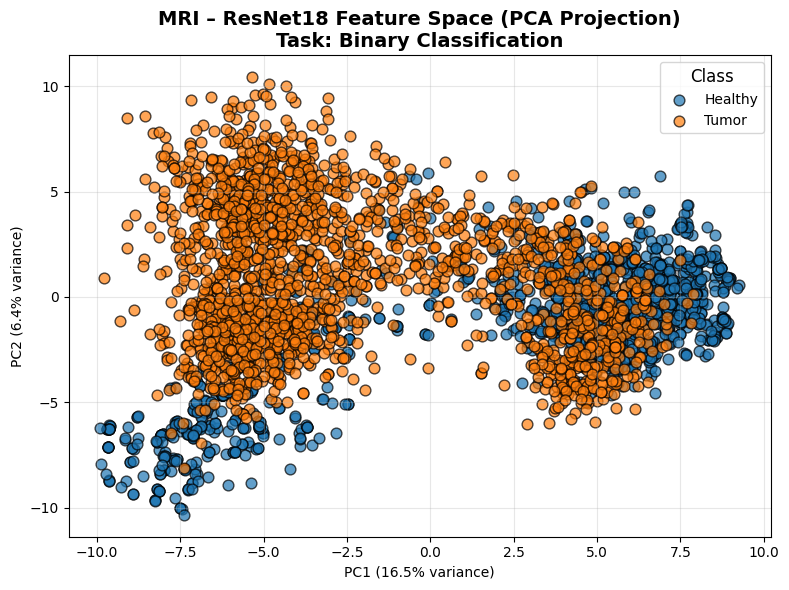

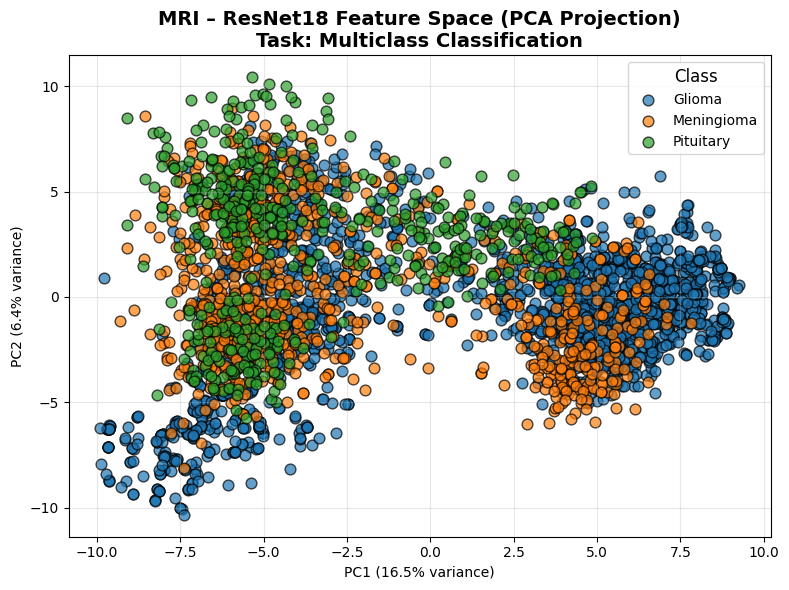

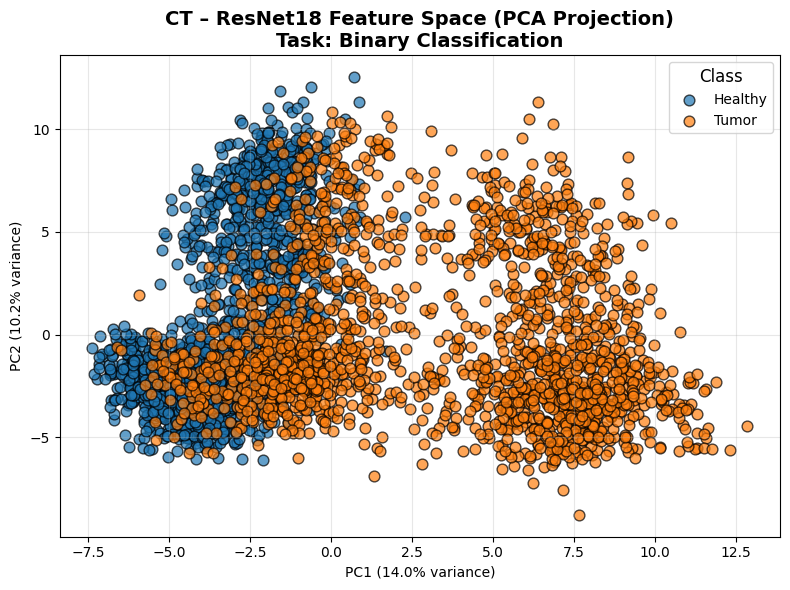

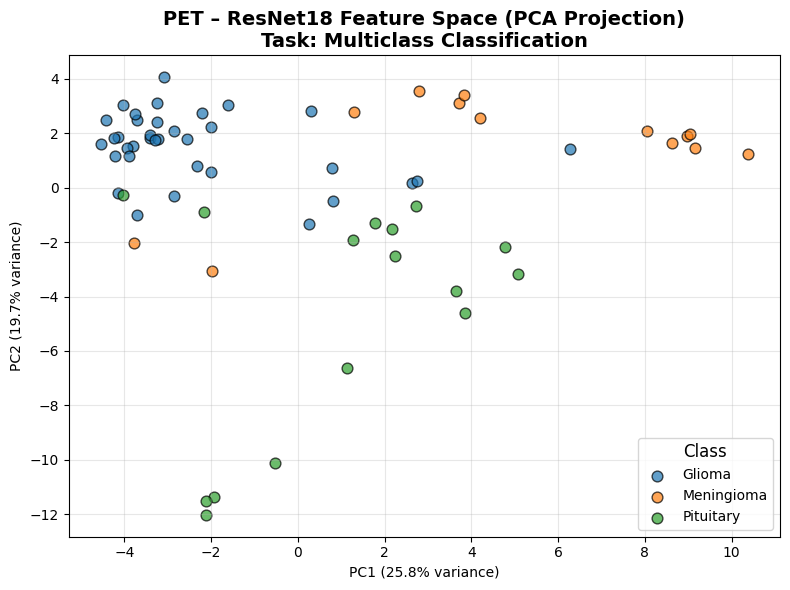


STEP 3 100% COMPLETE – ALL FEATURES EXTRACTED & VISUALIZED!
→ CNN embeddings (512-dim) and handcrafted features (37-dim) saved in 'features/' folder
→ Ready for Step 4: Model Training & Benchmarking


In [9]:
# ==================== PART 5 – Analysis & Visualization (For Dissertation) ====================
from sklearn.decomposition import PCA

def plot_pca(mod="mri", task="binary"):
    X = np.load(f"{FEATURES_ROOT}/cnn_{mod}_{task}_train_feat.npy")
    y = np.load(f"{FEATURES_ROOT}/cnn_{mod}_{task}_train_label.npy")
    
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(X)
    
    plt.figure(figsize=(8, 6))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    for i, c in enumerate(np.unique(y)):
        plt.scatter(reduced[y==c, 0], reduced[y==c, 1],
                   label=class_names[task][c],
                   alpha=0.7, edgecolors='k', s=60, color=colors[i])
    
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
    plt.title(f"{mod.upper()} – ResNet18 Feature Space (PCA Projection)\nTask: {task.capitalize()} Classification", 
              fontsize=14, fontweight='bold')
    plt.legend(title="Class", title_fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Generate the two key plots for your dissertation
plot_pca("mri", "binary")
plot_pca("mri", "multiclass")
plot_pca("ct", "binary")
plot_pca("pet", "multiclass")

print("\nSTEP 3 100% COMPLETE – ALL FEATURES EXTRACTED & VISUALIZED!")
print("→ CNN embeddings (512-dim) and handcrafted features (37-dim) saved in 'features/' folder")
print("→ Ready for Step 4: Model Training & Benchmarking")